In [41]:
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_core.tools import Tool
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
import pandas as pd

In [42]:
# Step 1: Create a DataFrame
df = pd.read_csv("movies_meta.csv")
df.head()

,original_title,release_date,collection,genres
0,Toy Story,1995-10-30,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,Jumanji,1995-12-15,NaN,"['Adventure', 'Fantasy', 'Family']"
2,Grumpier Old Men,1995-12-22,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,Waiting to Exhale,1995-12-22,NaN,"['Comedy', 'Drama', 'Romance']"
4,Father of the Bride Part II,1995-02-10,Father of the Bride Collection,['Comedy']


In [43]:
# initialize llm model
llm_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)


In [44]:
# Step 2: Define the Pandas DataFrame Tool
def pandas_agent_tool(input_query: str) -> str:
    llm = llm_model
    pandas_agent = create_pandas_dataframe_agent(
        llm, 
        df=df,
        allow_dangerous_code=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        verbose=False)
    response = pandas_agent.invoke({
        "input": input_query,
        "agent_scratchpad": f"Human: {input_query}\nAI: To answer this question, I need to use Python to analyze the dataframe. I'll use the python_repl_ast tool.\n\nAction: python_repl_ast\nAction Input: ",
    })
    return response

pandas_tool = Tool(
    name="PandasAgentTool",
    func=pandas_agent_tool,
    description="Useful for answering questions about a pandas DataFrame."
)

In [45]:
# Step 3: Define the Multiplication Tool
def multiply_values(input_query: str) -> str:
    try:
        # Parse the input (e.g., "5 * 3")
        values = [float(x.strip()) for x in input_query.split("*")]
        result = values[0] * values[1]
        return f"The result of multiplication is {result}."
    except Exception as e:
        return f"Error in multiplication: {e}"

multiplication_tool = Tool(
    name="MultiplicationTool",
    func=multiply_values,
    description="Useful for performing multiplication of two values. Input format: 'a * b'."
)

In [46]:
# Step 4: Create the LangGraph
tools = [pandas_tool, multiplication_tool]

llm_with_tools = llm_model.bind_tools(tools)

In [47]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

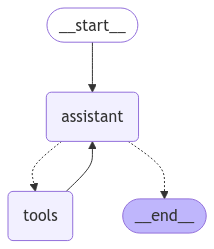

In [48]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [49]:
messages = [HumanMessage(content="multiply 3*4")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

multiply 3*4
================================== Ai Message ==================================
Tool Calls:
  MultiplicationTool (call_gDFbbSQ9os3zU4O7bNp2HFSB)
 Call ID: call_gDFbbSQ9os3zU4O7bNp2HFSB
  Args:
    __arg1: 3 * 4
================================= Tool Message =================================
Name: MultiplicationTool

The result of multiplication is 12.0.
================================== Ai Message ==================================

The result of multiplying 3 by 4 is 12.


In [50]:
messages = [HumanMessage(content="What are the available attributes in dataset")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the available attributes in dataset
================================== Ai Message ==================================
Tool Calls:
  PandasAgentTool (call_a6zGqkyyleu6vKXFFWiaGd08)
 Call ID: call_a6zGqkyyleu6vKXFFWiaGd08
  Args:
    __arg1: available attributes in dataset
================================= Tool Message =================================
Name: PandasAgentTool

{"input": "available attributes in dataset", "agent_scratchpad": "Human: available attributes in dataset\nAI: To answer this question, I need to use Python to analyze the dataframe. I'll use the python_repl_ast tool.\n\nAction: python_repl_ast\nAction Input: ", "output": "The available attributes in the dataset are:\n\n1. `original_title`\n2. `release_date`\n3. `collection`\n4. `genres`"}
================================== Ai Message ==================================

The available attributes in the dataset are:

1. `original_t

In [51]:
messages = [HumanMessage(content="list down all the movies from collection Toy story")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

list down all the movies from collection Toy story
================================== Ai Message ==================================
Tool Calls:
  PandasAgentTool (call_ui6jWsOTw2J8UBwyQv6kY0aS)
 Call ID: call_ui6jWsOTw2J8UBwyQv6kY0aS
  Args:
    __arg1: Toy Story
================================= Tool Message =================================
Name: PandasAgentTool

{"input": "Toy Story", "agent_scratchpad": "Human: Toy Story\nAI: To answer this question, I need to use Python to analyze the dataframe. I'll use the python_repl_ast tool.\n\nAction: python_repl_ast\nAction Input: ", "output": "\"Toy Story\" is a 1995 animated film produced by Pixar Animation Studios and released by Walt Disney Pictures. It was the first entirely computer-animated feature film and is widely regarded as a groundbreaking achievement in animation. The film follows the story of a group of toys that come to life when humans are not

In [52]:
messages = [HumanMessage(content="give me product of 5 and 4")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me product of 5 and 4
================================== Ai Message ==================================
Tool Calls:
  MultiplicationTool (call_1xdegWjS7fUjSobs5tq0edJb)
 Call ID: call_1xdegWjS7fUjSobs5tq0edJb
  Args:
    __arg1: 5 * 4
================================= Tool Message =================================
Name: MultiplicationTool

The result of multiplication is 20.0.
================================== Ai Message ==================================

The product of 5 and 4 is 20.


In [56]:
messages = [HumanMessage(content="get the number of movies per each year, plot a bar graph using plotly")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

get the number of movies per each year, plot a bar graph using plotly
================================== Ai Message ==================================
Tool Calls:
  PandasAgentTool (call_6vkgeINH6avpV3fQOHb1ZO8j)
 Call ID: call_6vkgeINH6avpV3fQOHb1ZO8j
  Args:
    __arg1: get the number of movies per each year
================================= Tool Message =================================
Name: PandasAgentTool

{"input": "get the number of movies per each year", "agent_scratchpad": "Human: get the number of movies per each year\nAI: To answer this question, I need to use Python to analyze the dataframe. I'll use the python_repl_ast tool.\n\nAction: python_repl_ast\nAction Input: ", "output": "The number of movies released per year is as follows (showing a few selected years for brevity):\n\n- 1874: 1 movie\n- 1878: 1 movie\n- 1883: 1 movie\n- 1887: 1 movie\n- 1888: 2 movies\n- ...\n- 2015: 1905 movies\n-